# Exploratory Data Analysis (EDA)


In [1]:
import os
import gc
import warnings

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuration
warnings.simplefilter('ignore')
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')

In [2]:
#import the data
path_s = './data/supplemental_files/'
path_t = './data/train_files/'
path_e = './data/example_test_files/'
path_stock = './data/'

In [3]:
%%time
train_price = pd.read_csv(f'{path_t}stock_prices.csv')
train_price_sec = pd.read_csv(f'{path_t}secondary_stock_prices.csv')
train_fins = pd.read_csv(f'{path_t}financials.csv')
train_opt = pd.read_csv(f'{path_t}options.csv')
train_trade = pd.read_csv(f'{path_t}trades.csv')
stocklist = pd.read_csv(f'{path_stock}stock_list.csv')

train_price.shape , train_price_sec.shape, train_fins.shape, train_opt.shape, train_trade.shape, stocklist.shape

Wall time: 14.3 s


((2332531, 12),
 (2384575, 12),
 (92956, 45),
 (3567694, 31),
 (1712, 56),
 (4417, 16))

In [4]:
print(f'stock price columns: {train_price.columns}')
print(f'secondary stock price columns: {train_price_sec.columns}')
print(f'financials columns: {train_fins.columns}')
print(f'options columns: {train_opt.columns}')
print(f'trades columns: {train_trade.columns}')

stock price columns: Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')
secondary stock price columns: Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')
financials columns: Index(['DisclosureNumber', 'DateCode', 'Date', 'SecuritiesCode',
       'DisclosedDate', 'DisclosedTime', 'DisclosedUnixTime', 'TypeOfDocument',
       'CurrentPeriodEndDate', 'TypeOfCurrentPeriod',
       'CurrentFiscalYearStartDate', 'CurrentFiscalYearEndDate', 'NetSales',
       'OperatingProfit', 'OrdinaryProfit', 'Profit', 'EarningsPerShare',
       'TotalAssets', 'Equity', 'EquityToAssetRatio', 'BookValuePerShare',
       'ResultDividendPerShare1stQuarter', 'ResultDividendPerShare2ndQuarter',
       'ResultDividendPerShare3rdQuarter',
 

# stock_price.csv
File Description
The core file of interest, including the daily closing price for each stock and the target column. Following is column information recorded in stock_price_spec.csv:

RowId: Unique ID of price records, the combination of Date and SecuritiesCode.

Date: Trade date.

SecuritiesCode: Local securities code.

Open: First traded price on a day.

High: Highest traded price on a day.

Low: Lowest traded price on a day.

Close: Last traded price on a day.

Volume: Number of traded stocks on a day.

AdjustmentFactor: Used to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares).

ExpectedDividend: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.

SupervisionFlag: Flag of securities under supervision and securities to be delisted, for more information, please see here.

Target: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

In [5]:
#stock and secondary stock price have the same columns
#so combine these two datasets
train_price = pd.concat([train_price, train_price_sec], ignore_index=True)
#also RowId is the primary key
train_price['RowId'].drop_duplicates()
train_price.info()
train_price['RowId'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4717106 entries, 0 to 4717105
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 400.4+ MB


4717106

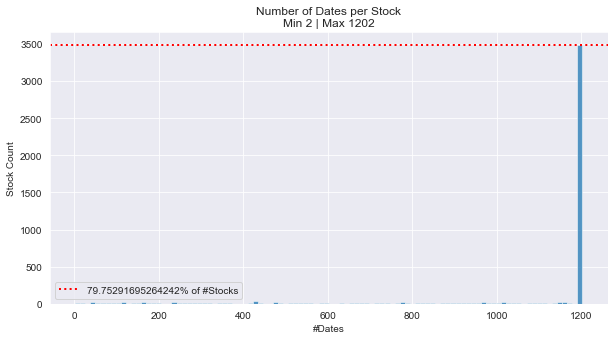

In [6]:
n_dates_per_stock = train_price.groupby(['SecuritiesCode'])['Date'].count()
stock_cnt_max = (n_dates_per_stock == n_dates_per_stock.max()).sum()
stock_ratio_max = stock_cnt_max / len(n_dates_per_stock) * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates per Stock\nMin {n_dates_per_stock.min()} | "
             f"Max {n_dates_per_stock.max()}")
ax.set_xlabel("#Dates")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

In [7]:
dates = train_price['Date'].nunique()
print(dates)

1202


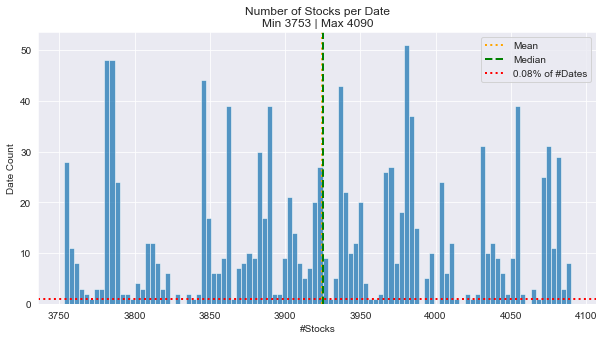

In [8]:
n_stocks_per_date = train_price.groupby(['Date'])['SecuritiesCode'].count()
date_cnt_max = (n_stocks_per_date == n_stocks_per_date.max()).sum()
date_ratio_max = round(date_cnt_max / len(n_stocks_per_date) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_stocks_per_date.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_stocks_per_date.mean(), color='orange', linestyle='dotted',
           linewidth=2, label='Mean')
ax.axvline(x=n_stocks_per_date.median(), color='green', linestyle='--',
           linewidth=2, label='Median')
ax.axhline(y=date_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{date_ratio_max}% of #Dates')
ax.set_title(f"Number of Stocks per Date\nMin {n_stocks_per_date.min()} | "
             f"Max {n_stocks_per_date.max()}")
ax.set_xlabel("#Stocks")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

In [33]:
no_price = train_price[train_price['Close'].isna()]
print(f'Number of samples without prices: {len(no_price)}')

Number of samples without prices: 99359


In [36]:
no_prices_per_date = no_price['Date'].value_counts().sort_index()
all_dates = sorted(no_price['Date'].unique())
no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=no_prices_per_date.index, 
                         y=no_prices_per_date, 
                         mode='lines'))
rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08',
    'y0': 4050, 'y1': 3950, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title=f"Number of Stocks without Prices per Date",
    xaxis_title="Date",
    yaxis_title="Stock Count",
)
fig.show()

Number of stocks without prices has a maximum on 2020-10-01

In [40]:
assert (len(train_price[train_price['Date'] == '2020-10-01']) == no_prices_per_date.max())

In [42]:
no_prices_per_date.max()

3997

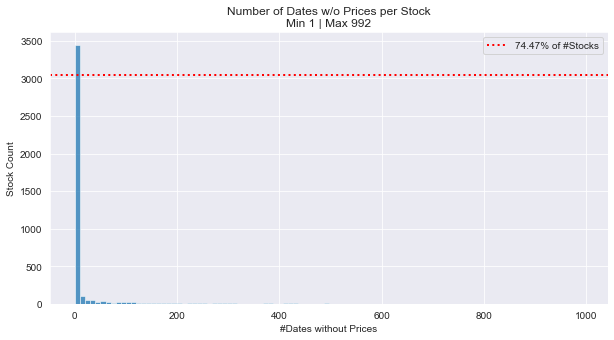

In [43]:
no_prices_per_stock = no_price['SecuritiesCode'].value_counts()
stock_cnt_max = (no_prices_per_stock == no_prices_per_stock.min()).sum()
stock_ratio_max = round(stock_cnt_max / len(no_prices_per_stock) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=no_prices_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% of #Stocks')
ax.set_title(f"Number of Dates w/o Prices per Stock\n"
             f"Min {no_prices_per_stock.min()} | "
             f"Max {no_prices_per_stock.max()}")
ax.set_xlabel("#Dates without Prices")
ax.set_ylabel("Stock Count")
ax.legend()
plt.show()

# trades.csv
File Description
Aggregated summary of trading volumes from the previous business week. Following is column information recorded in trades_spec.csv:

Date: Data published date, usually Thursday on the following week.

StartDate: The first trading date in this trading week.

EndDate: The last trading date in this trading week.

Section: Market division name.

In [45]:
train_trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 1712 non-null   object 
 1   StartDate                            765 non-null    object 
 2   EndDate                              765 non-null    object 
 3   Section                              765 non-null    object 
 4   TotalSales                           765 non-null    float64
 5   TotalPurchases                       765 non-null    float64
 6   TotalTotal                           765 non-null    float64
 7   TotalBalance                         765 non-null    float64
 8   ProprietarySales                     765 non-null    float64
 9   ProprietaryPurchases                 765 non-null    float64
 10  ProprietaryTotal                     765 non-null    float64
 11  ProprietaryBalance            

# options.csv
File Description
Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly. Following is column information recorded in options_spec.csv:

DateCode: Unique ID for option price records, the combintion of Date and OptionCode.

Date: Trade date and time.

OptionsCode: Local securities code. Detailed information is provided in Identification Code Specifications for Futures and Options Transactionssakimono20220208-e.pdf).

WholeDayOpen: Opening price for whole trading day.

WholeDayHigh: Highest price for whole trading day.

WholeDayLow: Lowest price for whole trading day.

WholeDayClose: Closing price for whole trading day.

NightSessionOpen: Opening price for night session.

NightSessionHigh: Highest price for night session.

NightSessionLow: Lowest price for night session.

NightSessionClose: Closing price for night session.

DaySessionOpen: Opening price for day session.

DaySessionHigh: Highest price for day session.

DaySessionLow: Lowest price for day session.

DaySessionClose: Closing price for day session.

TradingVolume: Trading volume of the product/contract for the whole trading day.

OpenInterest: Open interest of the product/contract for the whole trading day

TradingValue: Trading value of the product/contract for the whole trading day

ContractMonth: Cotract year-month of the product/contract.

StrikePrice: Exercise price of product/contract.

DaySessionVolume: Trading volume of the product/contract for day session.

Putcall: 1 for put and 2 for call.

LastTradingDay: Last trading day.

SpecialQuotationDay: The day when the Special Quotation is calculated.

SettlementPrice: Settlement price.

TheoreticalPrice: The theoretical price at the end of a day session.

BaseVolatility: The volatility at the time of calculating the settlement price.

ImpliedVolatility: Implied volatility.

InterestRate: Interest rate for calculation.

DividendRate: Dividend yeild.

Dividend: Devidend.

In [46]:
train_opt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3567694 entries, 0 to 3567693
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   DateCode             object 
 1   Date                 object 
 2   OptionsCode          int64  
 3   WholeDayOpen         float64
 4   WholeDayHigh         float64
 5   WholeDayLow          float64
 6   WholeDayClose        float64
 7   NightSessionOpen     object 
 8   NightSessionHigh     object 
 9   NightSessionLow      object 
 10  NightSessionClose    object 
 11  DaySessionOpen       float64
 12  DaySessionHigh       float64
 13  DaySessionLow        float64
 14  DaySessionClose      float64
 15  TradingVolume        int64  
 16  OpenInterest         int64  
 17  TradingValue         int64  
 18  ContractMonth        int64  
 19  StrikePrice          float64
 20  WholeDayVolume       int64  
 21  Putcall              int64  
 22  LastTradingDay       int64  
 23  SpecialQuotationDay  int64  
 24